In [1]:
import cv2
import os
from random import randint
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.datasets
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
from torch.autograd import Variable


"""
Data augmentation and Normalization for training
normalization for validation

"""

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'D://BISM/Awesome_CV-main/New folder/hymenoptera_data/hymenoptera_data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("class names : {}".format(class_names))
print("there are {} batches in the training set".format(len(dataloaders["train"])))
print("there are {} batches in the testing set".format(len(dataloaders["val"])))

print("there are {} images in the training set".format((dataset_sizes["train"])))
print("there are {} images in the testing set".format((dataset_sizes["val"])))

# loading the Resnet arch:
model_conv=torchvision.models.resnet18(pretrained=True)
#freeze all layers in the network:
for param in model_conv.parameters():
    param.requires_grad=False
#Get the number of inputs of the last layer:
model_ftrs=model_conv.fc.in_features
#Reconstruct the last layer to have two classes only:
model_conv.fc=nn.Linear(model_ftrs,2)
print(model_ftrs,model_conv.fc)

#now let us understand what is happening:
iteration=0
correct=0
for inputs,labels in dataloaders["train"]:
    if iteration==1:
        break
    inputs=Variable(inputs)
    labels=Variable(labels)
    print("input shape ",inputs.shape)
    print("label shape " ,labels.shape)
    print("labels are {}".format(labels))
    output=model_conv(inputs)
    print("output tensor ",output)
    print("output shape ", output.shape)
    _,predicted=torch.max(output,1)
    print("predected ",predicted)
    print("preddicted shape ",predicted.shape)
    correct+=(labels==predicted).sum()
    print("correct prediction ",correct)
    iteration+=1







class names : ['ants', 'bees']
there are 61 batches in the training set
there are 39 batches in the testing set
there are 244 images in the training set
there are 153 images in the testing set


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\kerolos/.cache\torch\checkpoints\resnet18-5c106cde.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:21<00:00, 2.18MB/s]


512 Linear(in_features=512, out_features=2, bias=True)
input shape  torch.Size([4, 3, 224, 224])
label shape  torch.Size([4])
labels are tensor([0, 0, 1, 0])
output tensor  tensor([[-0.0516, -0.4697],
        [-0.7132, -0.0594],
        [-0.8252,  0.0220],
        [-0.8242, -0.5048]], grad_fn=<AddmmBackward>)
output shape  torch.Size([4, 2])
predected  tensor([0, 1, 1, 1])
preddicted shape  torch.Size([4])
correct prediction  tensor(2)


In [3]:
import torch.optim as optim
from torch.optim import lr_scheduler

In [5]:
criteration=nn.CrossEntropyLoss()
optimizer=optim.SGD(model_conv.fc.parameters(),lr=0.001,momentum=0.9)
#decay learning rate:
exp_lr_schedular=lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

In [10]:

epoches=5
for epoch in range(epoches):
    
    exp_lr_schedular.step()
    correct=0
    for inputs,labels in dataloaders["train"]:

        
        inputs=Variable(inputs)
        labels=Variable(labels)
        
        optimizer.zero_grad()
        outputs=model_conv(inputs)
        loss=criteration(outputs,labels)
        loss.backward()
        optimizer.step()
        _,predicted=torch.max(output,1)
        correct+=(labels==predicted).sum()
        
    train_acc=correct*100/dataset_sizes["train"]
        
    print("{}/{} , training loss {} , train accuracy {} %".format(epoch,epoches,loss.item(),train_acc))
    
       


0/5 , training loss 0.020481113344430923 , train accuracy 51 %
1/5 , training loss 0.02741437591612339 , train accuracy 55 %
2/5 , training loss 0.12006381154060364 , train accuracy 47 %
3/5 , training loss 0.26791709661483765 , train accuracy 49 %
4/5 , training loss 0.08912180364131927 , train accuracy 48 %


In [19]:
# testing the model:
model_conv.eval()
with torch.no_grad():
    correct=0
    total=0
    for image,labels in dataloaders["val"]:
        image=Variable(image)
        labels=Variable(labels)
        output=model_conv(image)
        _,predicted=torch.max(output.data,1)
        correct+=(labels==predicted).sum().item()
        total=total+labels.size(0)
    print("the accuracy is {}".format(correct*100/total))
    
    

the accuracy is 94.11764705882354


In [20]:
labels.size(0)

1

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


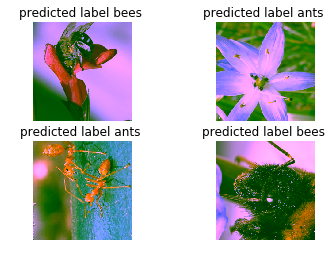

In [43]:
fig=plt.figure()
show_batch=0
index=0
with torch.no_grad():
    for image,labels in dataloaders["val"]:
        if show_batch==1:
            break
        show_batch+=1
        image=Variable(image)
        labels=Variable(labels)
        output=model_conv(image)
        _,predict=torch.max(output,1)
        
        for i in range(4):
            index+=1
            ax=plt.subplot(2,2,index)
            ax.axis("off")
            ax.set_title("predicted label {} ".format(class_names[predict[i]]))
            input_img=image.cpu().data[i]
            inp=input_img.numpy().transpose((2,1,0))
            mean=np.array([0.48,0.45,0.43])
            std=np.array([0.43,0.12,
                          0.67])
            inp=inp*std+mean
            inp=np.clip(inp,0,1)
            plt.imshow(inp)
            print(inp.shape)